In [63]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor


from keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout, Input
from keras.models import Model
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam

from matplotlib import pyplot as plt

In [2]:
bnb = pd.read_csv("AB_NYC_2019.csv")
bnb.head()
df = bnb.copy()

In [3]:
sub = pd.read_csv("subway.csv")
sub.head()

,Unnamed: 0,Station Latitude,Station Longitude
0,74,40.684460,-73.976890
1,82,40.599300,-73.955929
2,83,40.644031,-73.964492
3,94,40.640927,-73.963891
4,98,40.595246,-73.955161


In [4]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [5]:
def get_nearest_station(stations, x, y):
    stations['dist'] = ((stations['Station Latitude'] - x)**2 + (stations['Station Longitude'] - y)**2)
    return stations['Unnamed: 0'][stations['dist'] == stations['dist'].min()].values[0], stations['dist'].min()**(1/2)

nearest_stations = []
nearest_station_dist = []
for i in range(len(df)):
    if i%6000==0:
        print(i)
    station_id, dist = get_nearest_station(sub, df['latitude'][i], df['longitude'][i])
    nearest_stations.append(station_id)
    nearest_station_dist.append(dist)
df['nearest_station'] = nearest_stations
df['nearest_station_distance'] = nearest_station_dist

0
6000
12000
18000
24000
30000
36000
42000
48000


In [6]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,nearest_station,nearest_station_distance
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,83,0.008604
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,1175,0.003410
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365,1557,0.015821
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,919,0.004756
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,574,0.017631


In [7]:
# studing the number of nan values in each column
df.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
nearest_station                       0
nearest_station_distance              0
dtype: int64

In [8]:
# numerical features and their distribution
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,nearest_station,nearest_station_distance
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327,754.725289,0.018087
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289,455.235419,0.015027
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000,74.000000,0.000087
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000,372.000000,0.009168
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000,574.000000,0.014855
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000,1175.000000,0.022895
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000,1797.000000,0.266074


In [9]:
# id, host_id and name are unique and hence can be dropped
df.id.unique().size, df["host_id"].unique().size, df["name"].unique().size

(48895, 37457, 47906)

In [10]:
# dropping host id, ID, and name are mostly unique and have almost 0 correlation to price
df.drop(["id", "host_id", "name", "host_name"], axis = 1, inplace=True)

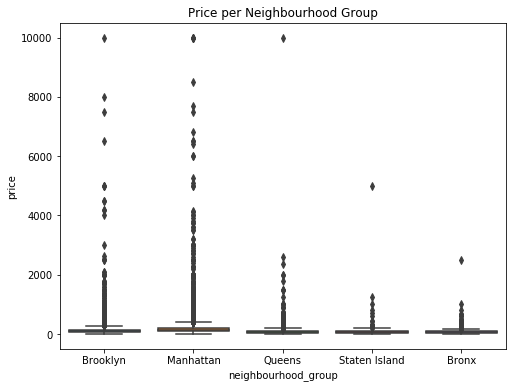

In [11]:
# plotting price and neighbourhood_group variation. We obeserve brooklyn and manhatten have more and coslier AirBnBs
x= 'neighbourhood_group'
y= 'price'
title = 'Price per Neighbourhood Group'

f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=x, y=y, data=df)
plt.title(title)
plt.ioff()

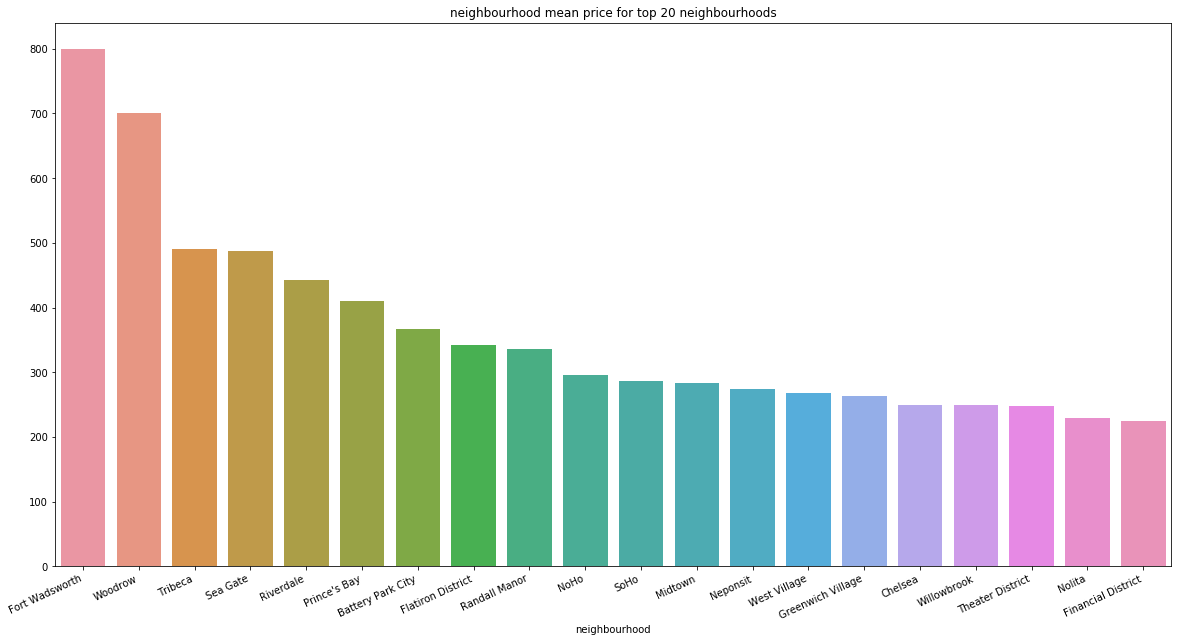

In [12]:
# plotting mean price of top 10 priced neighbourhoods. Neighbourhood is also an important feature as price varies with neighbourhood
neigh = df.groupby("neighbourhood").price.mean().sort_values(ascending = False).index[:20]
count = df.groupby("neighbourhood").price.mean().sort_values(ascending = False).values[:20]
plt.figure(figsize=(20,10))
f = sns.barplot(neigh, count)
f.set_title('neighbourhood mean price for top 20 neighbourhoods')
f.set_xticklabels(f.get_xticklabels(), rotation='25', ha="right");

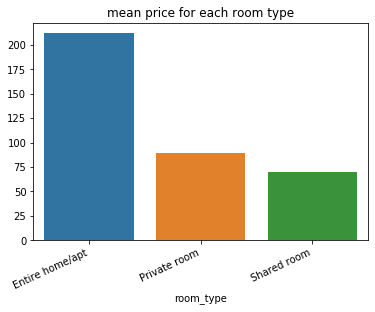

In [13]:
# plotting mean price and BnB type. BnB type greatly affects the price as well
room = df.groupby("room_type").price.mean().sort_values(ascending = False).index
price = df.groupby("room_type").price.mean().sort_values(ascending = False).values
f = sns.barplot(room, price)
f.set_title('mean price for each room type')
f.set_xticklabels(f.get_xticklabels(), rotation='25', ha="right");

In [14]:
# converting neighbourhood values to one hot encoded values
one_hot_neighbourhood = pd.get_dummies(df["neighbourhood"])
one_hot_neighbourhood.head()

,Allerton,Arden Heights,Arrochar,Arverne,Astoria,Bath Beach,Battery Park City,Bay Ridge,Bay Terrace,"Bay Terrace, Staten Island",...,Westerleigh,Whitestone,Williamsbridge,Williamsburg,Willowbrook,Windsor Terrace,Woodhaven,Woodlawn,Woodrow,Woodside
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# converting neighbourhood_groups to onehot encoded values
one_hot_neighbourhood_grp = pd.get_dummies(df["neighbourhood_group"])
one_hot_neighbourhood_grp.head()

,Bronx,Brooklyn,Manhattan,Queens,Staten Island
0,0,1,0,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,1,0,0,0
4,0,0,1,0,0


In [16]:
# converting room type to onehot encoded values
one_hot_room_type = pd.get_dummies(df["room_type"])
one_hot_room_type.head()

,Entire home/apt,Private room,Shared room
0,0,1,0
1,1,0,0
2,0,1,0
3,1,0,0
4,1,0,0


In [17]:
# we can drop these columns as we will be replacing them with their onehot encodings
df.drop(["neighbourhood", "neighbourhood_group", "room_type"], axis = 1, inplace = True)

In [18]:
# converting last_review date into number of days since the last overall review was written (which would be close to dataset release date)
date_max = pd.to_datetime(df.last_review).max()
df["last_review"] = (date_max - pd.to_datetime(df.last_review)).dt.days

In [19]:
# dropping price = 0 rows
one_hot_neighbourhood_grp = one_hot_neighbourhood_grp[df["price"]!=0].reset_index(drop = True)
one_hot_neighbourhood = one_hot_neighbourhood[df["price"]!=0].reset_index(drop = True)
one_hot_room_type = one_hot_room_type[df["price"]!=0].reset_index(drop = True)
df = df[df["price"]!=0].reset_index(drop = True)

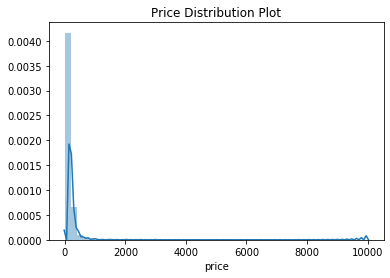

Text(0.5, 1.0, 'Log -Price Distribution Plot')

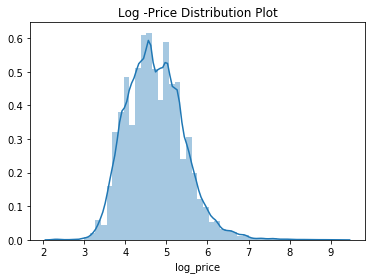

In [20]:
# plotting price distribution and log(price) distribution.
sns.distplot(df['price'])
plt.title("Price Distribution Plot")
plt.show()

df["log_price"] = np.log(df["price"])
sns.distplot(df["log_price"])
plt.title("Log -Price Distribution Plot")

In [21]:
# log price distribution is normal and hence will be more useful. We drop price and will instead use log(price)
df.drop("price", inplace=True, axis = 1)

In [22]:
# replacing nan values in reviews_per_month and last_review
df.loc[df["number_of_reviews"] == 0, "reviews_per_month"] = 0
df.loc[df["number_of_reviews"] == 0, "last_review"] = -1

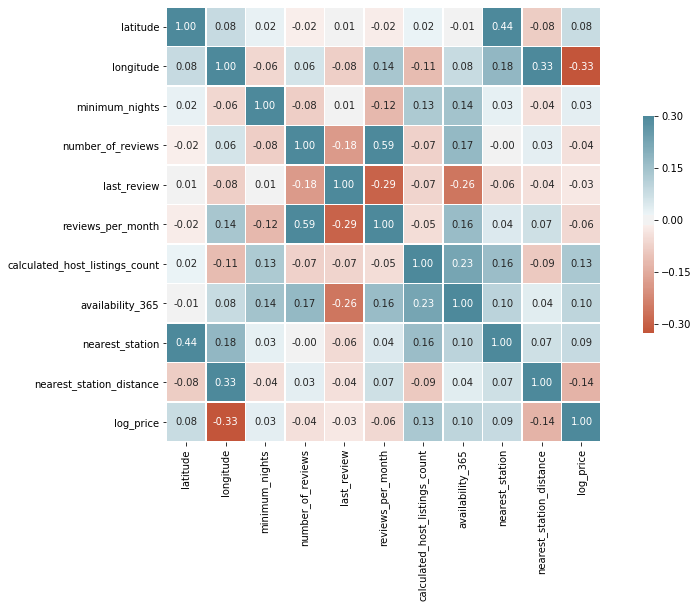

In [23]:
# correlation heat map of numerical features
C_mat = df.corr()
plt.figure(figsize=(15,8))
palette = sns.diverging_palette(20, 220, n=256)
sns.heatmap(C_mat, annot=True, fmt=".2f", cmap=palette, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.5}).set(ylim=(11, 0))
plt.show()

In [24]:
# checking if any nan values present in our data
df.isna().sum()

latitude                          0
longitude                         0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
nearest_station                   0
nearest_station_distance          0
log_price                         0
dtype: int64

## Linear Regression Model

In [25]:
results = pd.DataFrame(columns=["R-Squared(train)", "RMSE(train)", "R-squared(test)", "RMSE(test)", "MAE(train)", "MAE(test)"])
Y = df["log_price"]
X = df.drop(["log_price"], axis = 1).join(one_hot_neighbourhood).join(one_hot_neighbourhood_grp).join(one_hot_room_type)
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=18, test_size = 0.2)

In [73]:
linreg = LinearRegression(fit_intercept=False)
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [74]:
score_train = linreg.score(X_train, y_train)

#root mean squared error on train set
y_pred_train = linreg.predict(X_train)
lin_mse_train = mean_squared_error(y_train, y_pred_train)
lin_rmse_train = np.sqrt(lin_mse_train)
lin_mae_train = mean_absolute_error(y_train, y_pred_train)
print("R-squared score on train set:", score_train)  # r squared score on train set
print("Root mean-squared error on train set:", lin_rmse_train)
print("Mean-absolute error on train set:", lin_mae_train)


# r squared score on test set
score_test = linreg.score(X_test, y_test)

# mean squared error on test set
y_pred = linreg.predict(X_test)
lin_mse_test = mean_squared_error(y_test, y_pred)
lin_rmse_test = np.sqrt(lin_mse_test)
lin_mae_test = mean_absolute_error(y_test, y_pred)

print("R-squared score on test set:", score_test)
print("Root mean-squared error on test set:", lin_rmse_test)
print("Mean-absolute error on test set:", lin_mae_test)

results.loc["Logistic Regression"] = [score_train, lin_rmse_train, score_test, lin_rmse_test, lin_mae_train, lin_mae_test]

R-squared score on train set: 0.5474764117089436
Root mean-squared error on train set: 0.46919972961427303
Mean-absolute error on train set: 0.3387602245105804
R-squared score on test set: 0.5386290670499287
Root mean-squared error on test set: 0.47621367644736967
Mean-absolute error on test set: 0.3417999001040841


## Decision Tree

In [36]:
dtregr = DecisionTreeRegressor(max_depth=10)
dtregr.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [37]:
#r-squared score
score_train = dtregr.score(X_train, y_train)
#root mean squared error on train set
y_pred_train = dtregr.predict(X_train)
lin_mse_train = mean_squared_error(y_train, y_pred_train)
lin_rmse_train = np.sqrt(lin_mse_train)
lin_mae_train = mean_absolute_error(y_train, y_pred_train)
print('R-squared score on train set: {:.3f}'.format(score_train))
print("Root mean-squared error on train set:", lin_rmse_train)
print("Mean-absolute error on train set:", lin_mae_train)

score_test = dtregr.score(X_test, y_test)
y_pred = dtregr.predict(X_test)
lin_mse_test = mean_squared_error(y_test, y_pred)
lin_rmse_test = np.sqrt(lin_mse_test)
lin_mae_test = mean_absolute_error(y_test, y_pred)
print('R-squared score on test set: {:.3f}'.format(score_test))
print("Root mean-squared error on test set:", lin_rmse_test)
print("Mean-absolute error on test set:", lin_mae_test)

results.loc["Decision Tree"] = [score_train, lin_rmse_train, score_test, lin_rmse_test, lin_mae_train, lin_mae_test]

R-squared score on train set: 0.649
Root mean-squared error on train set: 0.4132016203022523
Mean-absolute error on train set: 0.29937341742839596
R-squared score on test set: 0.538
Root mean-squared error on test set: 0.47671876960316456
Mean-absolute error on test set: 0.33452643676609267


## Random Forest Model

In [38]:
regr = RandomForestRegressor(max_depth=20, random_state=0, n_estimators=50)
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [39]:
#r-squared score
score_train = regr.score(X_train, y_train)
#root mean squared error on train set
y_pred_train = regr.predict(X_train)
lin_mse_train = mean_squared_error(y_train, y_pred_train)
lin_rmse_train = np.sqrt(lin_mse_train)
lin_mae_train = mean_absolute_error(y_train, y_pred_train)
print('R-squared score on train set: {:.3f}'.format(score_train))
print("Root mean-squared error on test set:", lin_rmse_train)
print("Mean-absolute error on train set:", lin_mae_train)

score_test = regr.score(X_test, y_test)
y_pred = regr.predict(X_test)
lin_mse_test = mean_squared_error(y_test, y_pred)
lin_rmse_test = np.sqrt(lin_mse_test)
lin_mae_test = mean_absolute_error(y_test, y_pred)
print('R-squared score on test set: {:.3f}'.format(score_test))
print("Root mean-squared error on test set:", lin_rmse_test)
print("Mean-absolute error on test set:", lin_mae_test)


results.loc["Random Forest"] = [score_train, lin_rmse_train, score_test, lin_rmse_test, lin_mae_train, lin_mse_test]

R-squared score on train set: 0.902
Root mean-squared error on test set: 0.21857759993499404
Mean-absolute error on train set: 0.1615738371694131
R-squared score on test set: 0.603
Root mean-squared error on test set: 0.4416018966989786
Mean-absolute error on test set: 0.3125190062836925


In [40]:
# Random Forest with normalised features

norm = MinMaxScaler().fit(X_train)
X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)

In [41]:
regr = RandomForestRegressor(max_depth=20, random_state=0, n_estimators=50)
regr.fit(X_train_norm, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [42]:
#r-squared score
score_train = regr.score(X_train_norm, y_train)
#root mean squared error on train set
y_pred_train = regr.predict(X_train_norm)
lin_mse_train = mean_squared_error(y_train, y_pred_train)
lin_rmse_train = np.sqrt(lin_mse_train)
lin_mae_train = mean_absolute_error(y_train, y_pred_train)
print('R-squared score on train set: {:.3f}'.format(score_train))
print("Root mean-squared error on test set:", lin_rmse_train)
print("Mean-absolute error on train set:", lin_mae_train)

score_test = regr.score(X_test_norm, y_test)
y_pred = regr.predict(X_test_norm)
lin_mse_test = mean_squared_error(y_test, y_pred)
lin_rmse_test = np.sqrt(lin_mse_test)
lin_mae_test = mean_absolute_error(y_test, y_pred)
print('R-squared score on test set: {:.3f}'.format(score_test))
print("Root mean-squared error on test set:", lin_rmse_test)
print("Mean-absolute error on test set:", lin_mae_test)


results.loc["Random Forest(normalised)"] = [score_train, lin_rmse_train, score_test, lin_rmse_test, lin_mae_train, lin_mse_test]

R-squared score on train set: 0.902
Root mean-squared error on test set: 0.21857089410931593
Mean-absolute error on train set: 0.16153636631475743
R-squared score on test set: 0.603
Root mean-squared error on test set: 0.44181170303131734
Mean-absolute error on test set: 0.3126864058669092


## Deep learning model

In [43]:
# We generate a deep learning model consisting of 2 dence layers.
# Since our output is a number we use linear activation for output layer.
# We use mean absolute error as the loss function

In [44]:
BATCH_SIZE = 128

In [45]:
def get_model():
    inp = Input(shape=(X_train.shape[1],))
    x = Dense(100, kernel_initializer='normal', activation='relu')(inp)
    x = Dropout(0.25)(x)
    x = Dense(50, kernel_initializer='normal', activation='relu')(x)
    x = Dropout(0.25)(x)
#     x = Dense(128, kernel_initializer='normal', activation='relu')(x)
#     x = Dropout(0.25)(x)
    out = Dense(1, activation="linear", kernel_initializer='normal')(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(lr = 0.0005),
                  loss='mean_absolute_error',
                  metrics=['mean_absolute_error'])
    return model

In [46]:
model = get_model()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [47]:
 model.fit(X_train, y_train,epochs = 10, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))




Train on 39107 samples, validate on 9777 samples
Epoch 1/10





39107/39107 [==============================] - 3s 87us/step - loss: 1.4472 - mean_absolute_error: 1.4472 - val_loss: 0.7118 - val_mean_absolute_error: 0.7118
Epoch 2/10
39107/39107 [==============================] - 2s 55us/step - loss: 0.8020 - mean_absolute_error: 0.8020 - val_loss: 0.4767 - val_mean_absolute_error: 0.4767
Epoch 3/10
39107/39107 [==============================] - 3s 66us/step - loss: 0.7225 - mean_absolute_error: 0.7225 - val_loss: 0.4670 - val_mean_absolute_error: 0.4670
Epoch 4/10
39107/39107 [==============================] - 3s 68us/step - loss: 0.6808 - mean_absolute_error: 0.6808 - val_loss: 0.4144 - val_mean_absolute_error: 0.4144
Epoch 5/10
39107/39107 [==============================] - 3s 68us/step - loss: 0.6501 - mean_absolute_error: 0.6501 - val_loss: 0.3835 - val_mean_absolute_error: 0.3835
Epoch 6/10
39107/39107 [==============================] - 3s 65us/step - loss: 0.6201 - mean_absol

In [48]:
y_pred = model.predict(X_test).reshape(y_test.shape[0])
y_pred_train = model.predict(X_train).reshape(y_train.shape[0])

In [49]:
#r-squared score
score_train = r2_score(y_train, y_pred_train)
#root mean squared error on train set
lin_mse_train = mean_squared_error(y_train, y_pred_train)
lin_rmse_train = np.sqrt(lin_mse_train)
lin_mae_train = mean_absolute_error(y_train, y_pred_train)
print('R-squared score on train set: {:.3f}'.format(score_train))
print("Root mean-squared error on test set:", lin_rmse_train)
print("Mean-absolute error on train set:", lin_mae_train)

score_test = r2_score(y_test, y_pred)
lin_mse_test = mean_squared_error(y_test, y_pred)
lin_rmse_test = np.sqrt(lin_mse_test)
lin_mae_test = mean_absolute_error(y_test, y_pred)
print('R-squared score on test set: {:.3f}'.format(score_test))
print("Root mean-squared error on test set:", lin_rmse_test)
print("Mean-absolute error on test set:", lin_mae_test)


results.loc["Deep Learning model"] = [score_train, lin_rmse_train, score_test, lin_rmse_test, lin_mae_train, lin_mse_test]

R-squared score on train set: 0.426
Root mean-squared error on test set: 0.5282633738385972
Mean-absolute error on train set: 0.3732686781035067
R-squared score on test set: 0.426
Root mean-squared error on test set: 0.5312415353722592
Mean-absolute error on test set: 0.3766664805088901


## Results

In [50]:
results

,R-Squared(train),RMSE(train),R-squared(test),RMSE(test),MAE(train),MAE(test)
Logistic Regression,0.547476,0.469200,0.538629,0.476214,0.338760,0.341800
Decision Tree,0.649046,0.413202,0.537650,0.476719,0.299373,0.334526
Random Forest,0.901794,0.218578,0.603258,0.441602,0.161574,0.195012
Random Forest(normalised),0.901800,0.218571,0.602881,0.441812,0.161536,0.195198
Deep Learning model,0.426377,0.528263,0.425843,0.531242,0.373269,0.282218


In [51]:
# Feature importance scores for top 10 features
feature_importances = regr.feature_importances_
top_10 = sorted(zip(feature_importances, X.columns), reverse = True)[:10]

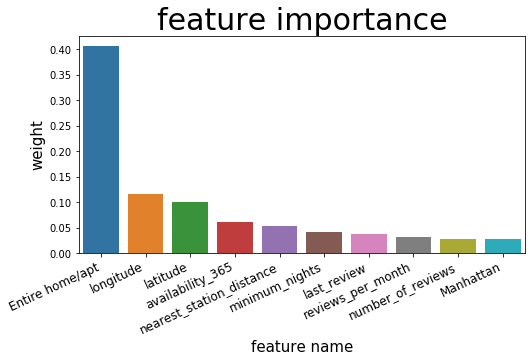

In [52]:
weights, features = [top_10[i][0] for i in range(10)], [top_10[i][1] for i in range(10)]
plt.figure(figsize=(8, 4))
plt.xlabel('feature name', fontsize = 15)
plt.ylabel('weight', fontsize = 15)
f = sns.barplot(features, weights)
f.set_title('feature importance', fontsize = 30)
f.set_xticklabels(f.get_xticklabels(), rotation='25', ha="right", fontsize = 12);

## Predict from csv

In [53]:
def predict(reg, test_data):
    # get nearest station
    nearest_stations = []
    nearest_station_dist = []
    for i in range(len(test_data)):
        station_id, dist = get_nearest_station(sub, test_data['latitude'][i], test_data['longitude'][i])
        nearest_stations.append(station_id)
        nearest_station_dist.append(dist)
    test_data['nearest_station'] = nearest_stations
    test_data['nearest_station_distance'] = nearest_station_dist
    
    ids = pd.DataFrame(test_data.id)
    tp = pd.DataFrame(test_data.price)
    test_data.drop(["id", "host_id", "name", "host_name"], axis = 1, inplace=True)
    ngh = pd.DataFrame(np.zeros((len(test_data),len(one_hot_neighbourhood.columns)), dtype = int),columns=one_hot_neighbourhood.columns)
    ngh_grp = pd.DataFrame(np.zeros((len(test_data),len(one_hot_neighbourhood_grp.columns)), dtype = int),columns=one_hot_neighbourhood_grp.columns)
    rt = pd.DataFrame(np.zeros((len(test_data),len(one_hot_room_type.columns)), dtype = int), columns=one_hot_room_type.columns)
    
    
    to_drop = test_data[test_data['price']==0].index
    if len(to_drop) > 0:
        test_data = test_data.drop(to_drop).reset_index(drop=True)
        ngh = ngh.drop(to_drop).reset_index(drop=True)
        ngh_grp = ngh_grp.drop(to_drop).reset_index(drop=True)
        rt = rt.drop(to_drop).reset_index(drop=True)
        ids = ids.drop(to_drop).reset_index(drop=True)
        tp = tp.drop(to_drop).reset_index(drop=True)

    test_data.drop("price", inplace=True, axis = 1)
    
    for i in range(len(test_data)):
        ngh_i, ngh_grp_i, rt_i = test_data['neighbourhood'][i], test_data['neighbourhood_group'][i], test_data['room_type'][i]
        ngh[ngh_i][i], ngh_grp[ngh_grp_i][i], rt[rt_i][i] = 1,1,1
    
    test_data.drop(["neighbourhood", "neighbourhood_group", "room_type"], axis = 1, inplace = True)
    
    date_max = pd.to_datetime(bnb.last_review).max()
    test_data["last_review"] = (date_max - pd.to_datetime(test_data.last_review)).dt.days
    
    test_data.loc[test_data["number_of_reviews"] == 0, "reviews_per_month"] = 0
    test_data.loc[test_data["number_of_reviews"] == 0, "last_review"] = -1
    
    preds = reg.predict(test_data.join(ngh).join(ngh_grp).join(rt))
    test_data['log_preds'] = preds
    test_data['preds'] = np.e**preds
    test_data['ID'] = ids.id
    test_data['True Price'] = tp.price
    return test_data

In [54]:
df = pd.read_csv('bnb_test.csv')

In [55]:
td = df.copy()

In [56]:
res = predict(regr, td)

In [57]:
res.head()

,latitude,longitude,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,nearest_station,nearest_station_distance,log_preds,preds,ID,True Price
0,40.73279,-73.98746,12,1,1406.0,0.02,2,164,372,0.019251,6.006785,406.175550,5279925,140
1,40.71846,-73.98727,2,2,1017.0,0.05,1,0,372,0.012627,4.756133,116.295289,9311761,150
2,40.75393,-73.96612,30,5,55.0,0.34,91,304,1452,0.010231,6.010007,407.486352,24497080,125
3,40.78626,-73.94295,6,0,-1.0,0.00,1,0,574,0.020954,4.832995,125.586562,9693821,200
4,40.82829,-73.94691,5,0,-1.0,0.00,2,363,774,0.008894,4.448684,85.514302,24139687,80


In [58]:
res.to_csv("bnb_results.csv", index = False)

In [59]:
# saving test data to csv
bnb.loc[X_test.index].to_csv('bnb_test.csv', index = False)

In [60]:
feats = pd.DataFrame(columns=['Feature', 'Weight'])
feats['Feature'] = X.columns
feats['Weight'] = feature_importances
feats = feats.sort_values(by='Weight', ascending = False).reset_index(drop = True)
feats

,Feature,Weight
0,Entire home/apt,4.060918e-01
1,longitude,1.159140e-01
2,latitude,1.002080e-01
3,availability_365,6.180000e-02
4,nearest_station_distance,5.298107e-02
...,...,...
234,Lighthouse Hill,2.023721e-07
235,Silver Lake,1.927776e-07
236,Rossville,4.833106e-08
237,Howland Hook,3.717690e-09


In [61]:
feats

,Feature,Weight
0,Entire home/apt,4.060918e-01
1,longitude,1.159140e-01
2,latitude,1.002080e-01
3,availability_365,6.180000e-02
4,nearest_station_distance,5.298107e-02
...,...,...
234,Lighthouse Hill,2.023721e-07
235,Silver Lake,1.927776e-07
236,Rossville,4.833106e-08
237,Howland Hook,3.717690e-09


In [64]:
gbregr = GradientBoostingRegressor()
gbregr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [65]:
y_pred_train = gbregr.predict(X_train)
score_train = gbregr.score(X_train, y_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_pred_train)

# makes prediction and retrieves R-squared, RMSE, MAE (test)
y_pred = gbregr.predict(X_test)
score_test = gbregr.score(X_test, y_test)
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred)

results.loc["Gradient Boosting Regressor"] = [score_train, rmse_train, mae_train , score_test, rmse_test, mae_test]

In [66]:
results

,R-Squared(train),RMSE(train),R-squared(test),RMSE(test),MAE(train),MAE(test)
Logistic Regression,0.547476,0.469200,0.538629,0.476214,0.338760,0.341800
Decision Tree,0.649046,0.413202,0.537650,0.476719,0.299373,0.334526
Random Forest,0.901794,0.218578,0.603258,0.441602,0.161574,0.195012
Random Forest(normalised),0.901800,0.218571,0.602881,0.441812,0.161536,0.195198
Deep Learning model,0.426377,0.528263,0.425843,0.531242,0.373269,0.282218
Gradient Boosting Regressor,0.598602,0.441901,0.317674,0.585317,0.451476,0.323215
